<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/10_Time_Series_Forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series-Forecasting-with-TensorFlow + MileStone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin

⚠️ **Note:** This is not a financial advice!!!

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future prices of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-24 02:24:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-06-24 02:24:01 (7.20 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Import TimeSeries with Pandas

In [ ]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])    # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically, deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

Below is a table showcasing what would collecting one sample at different time frames result in:

1 sample per timeframe | Number of samples per year
---------------------- | --------------------------
Second | 31,536,000
Hour | 8,760
Day | 365
Week | 52
Month | 12

> 🔑 **Note:** The **seasonality** of a time series dataset is referred to as the number of samples per year. So, for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


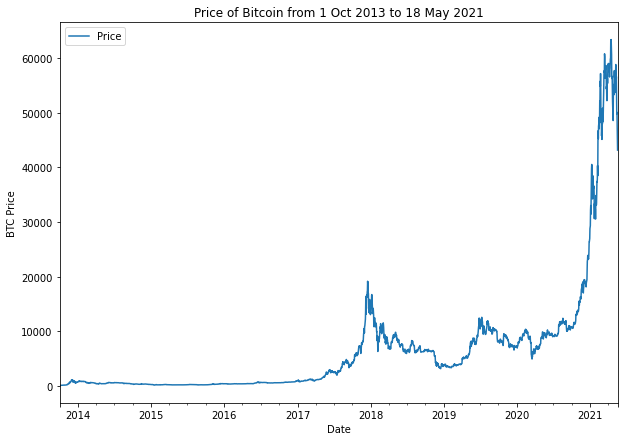

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.legend();

## Importing time series data with Python's CSV Module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader)    # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))    # get the dates as dates (not strings)
        btc_price.append(float(line[2]))    # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

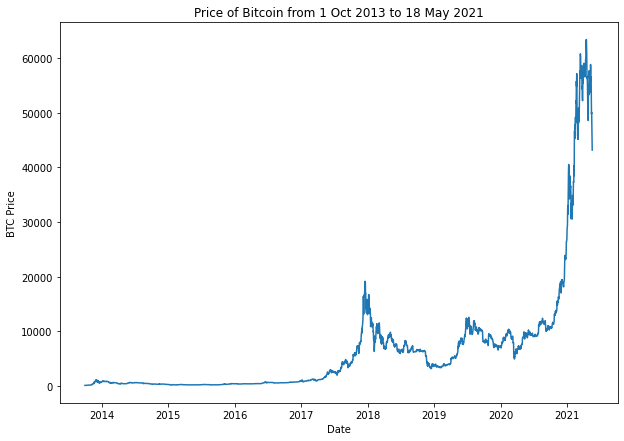

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

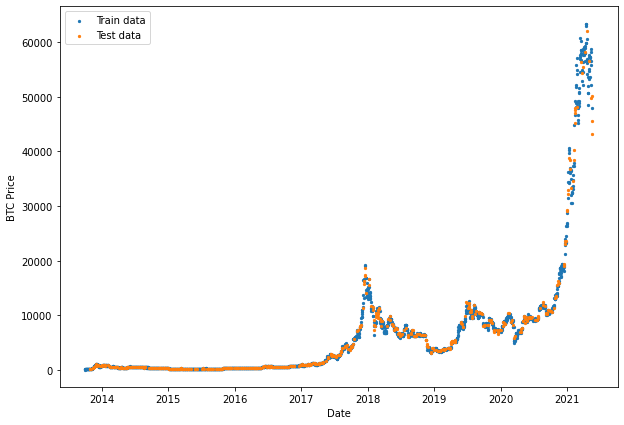

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits for timeseries data the right way
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

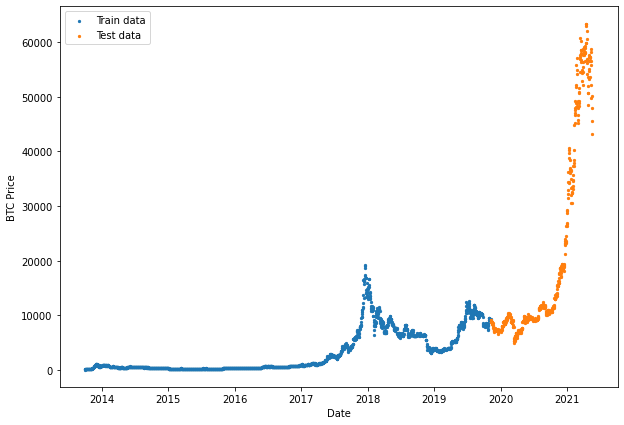

In [ ]:
# Let's plot correct train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

## Create a plotting function

Typing ploting code is tedious, let's functionize it...

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of ploe, default = "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

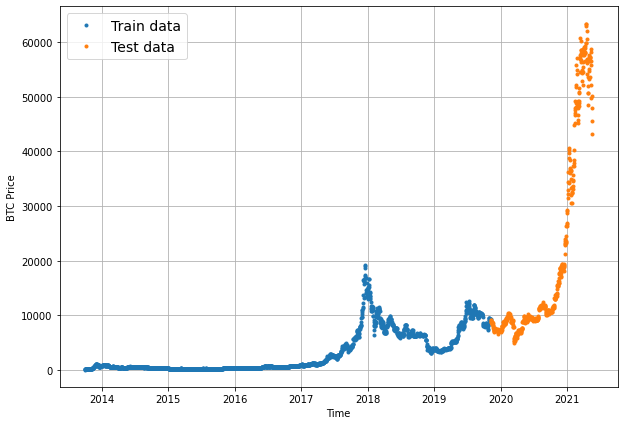

In [ ]:
# Test our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon:** Number of timesteps into the future we're going to predict
* **Window size:** Number of timesteps we're going to use to predict *horizon*

Modelling experiments, we're running...

Model Number | Model Type | Horizon size | Window size | Extra data
------------ | ---------- | ------------ | ----------- | ----------
0 | Naïve model (baseline) | NA | NA | NA
1 | Dense model | 1 | 7 | NA
2 | Same architecture as 1 | 1 | 30 | NA
3 | Same architecture as 1 | 7 | 30 | NA
4 | Conv1D | 1 | 7 | NA
5 | LSTM | 1 | 7 | NA
6 | Same as architecture 1 (but with multivariate data) | 1 | 7 | Block reward size
7 | N-BEATs Algorithm | 1 | 7 | NA
8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA
9 | Future prediction model (model to predict future values) | 1 | 7 | NA
10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA

## Model 0: Naïve forecast (Baseline)

The formula looks like:
$$\hat{y}_{t} = y_{t-1}$$

In layman's terms:

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

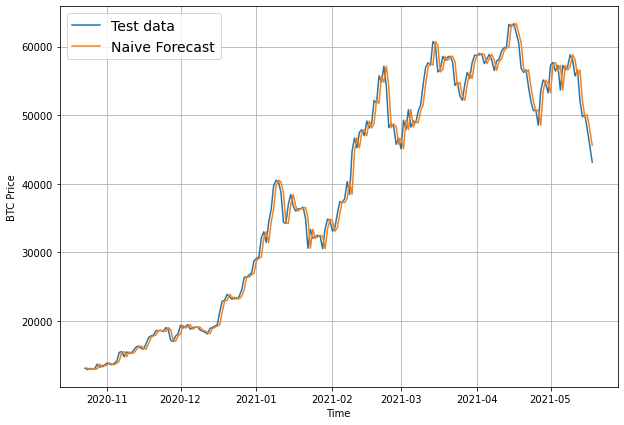

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, start=350, format="-", label="Test data")
plot_time_series(X_test[1:], naive_forecast, start=350, format="-", label="Naive Forecast")

 >  🛠 **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. And have a search to find out why the naïve forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a numbers, so that means we have a form of regression problem.

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* MAPE/sMAPE - (Symmetric) Mean Absolute Percentage Error
* MASE - Mean Absolute Scaled Error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is **how does our model's forecasts (y_pred) compare against the actual values (y_true/ground truth values)**? 

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [ ]:
import tensorflow as tf

The formula for MASE is:

$$
q_{j} = \frac{e_{j}} {\frac{1} {T - 1}\sum_{t=2}^{T} \mid {y_{t} - y_{t - 1}}\mid}
$$

$$
MASE = mean(\mid q_{j} \mid) 
$$

In [21]:
# MASE Implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [23]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [28]:
# Create a function to take in model predictions and truth values and return various evaluation metrics
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

Let's now see if it works...

In [29]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [30]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

In [31]:
# Find minimum and maximum prices of Bitcoin in test dataset
tf.reduce_min(y_test).numpy(), tf.reduce_max(y_test).numpy()

(4944.7023359837, 63346.7890351052)

## Other models you can use for baslines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: 

Model/Library Name | Resource
------------------ | --------
Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime
TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests
Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats
LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our timeseries dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [37]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

In [33]:
# What we want to with our bitcoin data?
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [34]:
# Let's setup global variables for window size and horizon
HORIZON = 1     # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [53]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [54]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window)} -> Label: {tf.squeeze(test_label)}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our time series.

We could do this with Python for loops, however, for large time series, that would be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#).

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function we're about to create has been adapted from this [article](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [84]:
import numpy as np

# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windoes of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T    # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a timeseries) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [87]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [89]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon: [125.96116]


In [90]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i - 3]} -> Horizon: {full_labels[i - 3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Horizon: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Horizon: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Horizon: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array), an extension could be to try and replicate what we've done using the premade function.

## Turning windows into training and test sets

In [98]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))   # this will default to 80% train / 20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [99]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [100]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [101]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))